### 📦 Import libraries

In [1]:
# Built-in libraries
import os
from collections import defaultdict

# Third-party libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D,
    LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)


2025-08-10 13:30:57.029605: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 13:30:57.077320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-10 13:30:57.077351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-10 13:30:57.079049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-10 13:30:57.089499: I tensorflow/core/platform/cpu_feature_guar

### 📂 Load and parse image dataset

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /mnt/a/dataset/deepfake/Model/MobileNet_LSTM_Adamax


In [3]:
# Đường dẫn dataset và nhãn
base_path = '/mnt/a/dataset/deepfake/Dataset/celeb_df_crop'
categories = ['fake', 'real']

data = []

# Duyệt qua từng ảnh trong thư mục fake/real
for label in categories:
    folder_path = os.path.join(base_path, label)
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jpg'):
            continue
        try:
            id_part, frame_part = filename.split('_frame_')
            sample_id = int(id_part.split('_')[0])
            frame_idx = int(frame_part.split('.')[0])
            data.append({
                'filename': filename,
                'path': os.path.join(folder_path, filename),
                'id': sample_id,
                'frame': frame_idx,
                'label': label
            })
        except ValueError:
            # Bỏ qua ảnh sai định dạng
            continue

# Chuyển về DataFrame
df = pd.DataFrame(data)


In [4]:
df

,filename,path,id,frame,label
0,000_id0_0000_frame_0000.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,0,0,fake
1,000_id0_0000_frame_0001.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,0,1,fake
2,000_id0_0000_frame_0002.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,0,2,fake
3,000_id0_0000_frame_0003.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,0,3,fake
4,000_id0_0000_frame_0004.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,0,4,fake
...,...,...,...,...,...
32367,541_id9_0009_frame_0025.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,541,25,real
32368,541_id9_0009_frame_0026.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,541,26,real
32369,541_id9_0009_frame_0027.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,541,27,real
32370,541_id9_0009_frame_0028.jpg,/mnt/a/dataset/deepfake/Dataset/celeb_df_crop/...,541,28,real


### 🔁 Encode label

In [5]:
# Chuyển nhãn về số: fake=0, real=1
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})


### 🎞️ Group frames by video

In [6]:
# Tạo khóa duy nhất cho mỗi video dựa trên id và nhãn
df['video_key'] = df['id'].astype(str) + "_" + df['label']

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


### 🏷️ Check label dictionary

In [7]:
labels  # Kiểm tra dict chứa nhãn video

{'0_fake': 0,
 '1_fake': 0,
 '2_fake': 0,
 '3_fake': 0,
 '4_fake': 0,
 '5_fake': 0,
 '6_fake': 0,
 '7_fake': 0,
 '8_fake': 0,
 '9_fake': 0,
 '10_fake': 0,
 '11_fake': 0,
 '12_fake': 0,
 '13_fake': 0,
 '14_fake': 0,
 '15_fake': 0,
 '16_fake': 0,
 '17_fake': 0,
 '18_fake': 0,
 '19_fake': 0,
 '20_fake': 0,
 '21_fake': 0,
 '22_fake': 0,
 '23_fake': 0,
 '24_fake': 0,
 '25_fake': 0,
 '26_fake': 0,
 '27_fake': 0,
 '28_fake': 0,
 '29_fake': 0,
 '30_fake': 0,
 '31_fake': 0,
 '32_fake': 0,
 '33_fake': 0,
 '34_fake': 0,
 '35_fake': 0,
 '36_fake': 0,
 '37_fake': 0,
 '38_fake': 0,
 '39_fake': 0,
 '40_fake': 0,
 '41_fake': 0,
 '42_fake': 0,
 '43_fake': 0,
 '44_fake': 0,
 '45_fake': 0,
 '46_fake': 0,
 '47_fake': 0,
 '48_fake': 0,
 '49_fake': 0,
 '50_fake': 0,
 '51_fake': 0,
 '52_fake': 0,
 '53_fake': 0,
 '54_fake': 0,
 '55_fake': 0,
 '56_fake': 0,
 '57_fake': 0,
 '58_fake': 0,
 '59_fake': 0,
 '60_fake': 0,
 '61_fake': 0,
 '62_fake': 0,
 '63_fake': 0,
 '64_fake': 0,
 '65_fake': 0,
 '66_fake': 0,
 '67_

In [8]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode

# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Data generator
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            for path in frames:
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# Build model cải tiến
def build_model(sequence_len, img_size):
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')

    # Freeze toàn bộ backbone để giảm overfit
    base_cnn.trainable = False

    # CNN feature extractor
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    # Sequence input
    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)

    # LSTM đơn giản hơn
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Không dùng nhiều Dense, chỉ một đầu ra
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# HMM cải tiến
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0  # fallback
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


2025-08-10 13:31:03.731363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 13:31:03.797610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 13:31:03.797660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 13:31:03.803195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 13:31:03.803335: I external/local_xla/xla/stream_executor

Epoch 1/50


2025-08-10 13:31:16.384293: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-08-10 13:31:16.740961: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-10 13:31:19.066054: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2d083ddb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-10 13:31:19.066128: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-08-10 13:31:19.070981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754807479.131783   56677 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.5295
Epoch 1: val_accuracy improved from -inf to 0.55172, saving model to best_model_fold1.h5


/home/nhutai/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 148s 3s/step - loss: 0.7092 - accuracy: 0.5295 - val_loss: 0.6945 - val_accuracy: 0.5517 - lr: 1.0000e-04
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5718
Epoch 2: val_accuracy did not improve from 0.55172
49/49 [==============================] - 149s 3s/step - loss: 0.6826 - accuracy: 0.5718 - val_loss: 0.6856 - val_accuracy: 0.5517 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5705
Epoch 3: val_accuracy did not improve from 0.55172
49/49 [==============================] - 165s 3s/step - loss: 0.6817 - accuracy: 0.5705 - val_loss: 0.6868 - val_accuracy: 0.5402 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.6128
Epoch 4: val_accuracy improved from 0.55172 to 0.58621, saving model to best_model_fold1.h5
49/49 [==============================] - 115s 2s/step - loss: 0.6588 - accuracy: 0.

/home/nhutai/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 160s 3s/step - loss: 0.7242 - accuracy: 0.5077 - val_loss: 0.6968 - val_accuracy: 0.5172 - lr: 1.0000e-04
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5487
Epoch 2: val_accuracy improved from 0.51724 to 0.54023, saving model to best_model_fold2.h5
49/49 [==============================] - 153s 3s/step - loss: 0.6948 - accuracy: 0.5487 - val_loss: 0.6848 - val_accuracy: 0.5402 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5577
Epoch 3: val_accuracy improved from 0.54023 to 0.57471, saving model to best_model_fold2.h5
49/49 [==============================] - 115s 2s/step - loss: 0.6887 - accuracy: 0.5577 - val_loss: 0.6748 - val_accuracy: 0.5747 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.5923
Epoch 4: val_accuracy improved from 0.57471 to 0.58621, saving model to best_model_fold2.h5
4

/home/nhutai/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 109s 2s/step - loss: 0.7154 - accuracy: 0.5372 - val_loss: 0.6648 - val_accuracy: 0.6322 - lr: 1.0000e-04
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.5385
Epoch 2: val_accuracy improved from 0.63218 to 0.67816, saving model to best_model_fold3.h5
49/49 [==============================] - 106s 2s/step - loss: 0.7021 - accuracy: 0.5385 - val_loss: 0.6573 - val_accuracy: 0.6782 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.5449
Epoch 3: val_accuracy did not improve from 0.67816
49/49 [==============================] - 102s 2s/step - loss: 0.6989 - accuracy: 0.5449 - val_loss: 0.6566 - val_accuracy: 0.5862 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.5923
Epoch 4: val_accuracy did not improve from 0.67816
49/49 [==============================] - 106s 2s/step - loss: 0.6699 - accuracy: 0.

/home/nhutai/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 118s 2s/step - loss: 0.7318 - accuracy: 0.5000 - val_loss: 0.7088 - val_accuracy: 0.5172 - lr: 1.0000e-04
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5615
Epoch 2: val_accuracy improved from 0.51724 to 0.55172, saving model to best_model_fold4.h5
49/49 [==============================] - 134s 3s/step - loss: 0.6910 - accuracy: 0.5615 - val_loss: 0.6960 - val_accuracy: 0.5517 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.5397
Epoch 3: val_accuracy improved from 0.55172 to 0.57471, saving model to best_model_fold4.h5
49/49 [==============================] - 153s 3s/step - loss: 0.6994 - accuracy: 0.5397 - val_loss: 0.6871 - val_accuracy: 0.5747 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5731
Epoch 4: val_accuracy improved from 0.57471 to 0.60920, saving model to best_model_fold4.h5
4

/home/nhutai/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 120s 2s/step - loss: 0.7307 - accuracy: 0.4942 - val_loss: 0.6704 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5519
Epoch 2: val_accuracy improved from 0.59770 to 0.60920, saving model to best_model_fold5.h5
49/49 [==============================] - 129s 3s/step - loss: 0.6912 - accuracy: 0.5519 - val_loss: 0.6455 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.5711
Epoch 3: val_accuracy did not improve from 0.60920
49/49 [==============================] - 157s 3s/step - loss: 0.6784 - accuracy: 0.5711 - val_loss: 0.6436 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6018
Epoch 4: val_accuracy did not improve from 0.60920
49/49 [==============================] - 162s 3s/step - loss: 0.6606 - accuracy: 0.

In [10]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.745264
precision    0.760828
recall       0.737717
f1           0.747004
auc          0.684878
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.792627,0.853933,0.703704,0.771574,0.715936
1,2,0.718894,0.723810,0.703704,0.713615,0.698012
2,3,0.967742,1.000000,0.935780,0.966825,0.724601
3,4,0.635945,0.622951,0.697248,0.658009,0.638209
4,5,0.611111,0.603448,0.648148,0.625000,0.647634


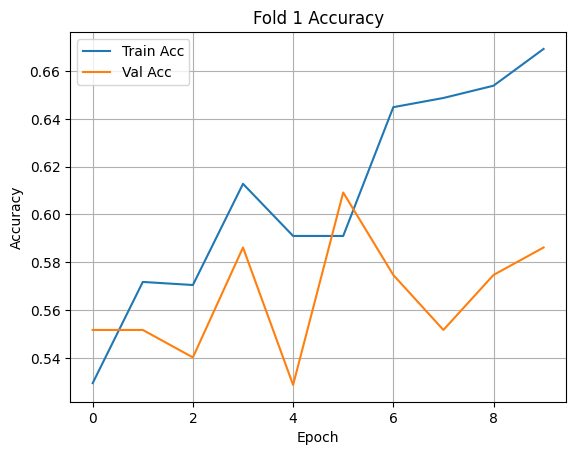

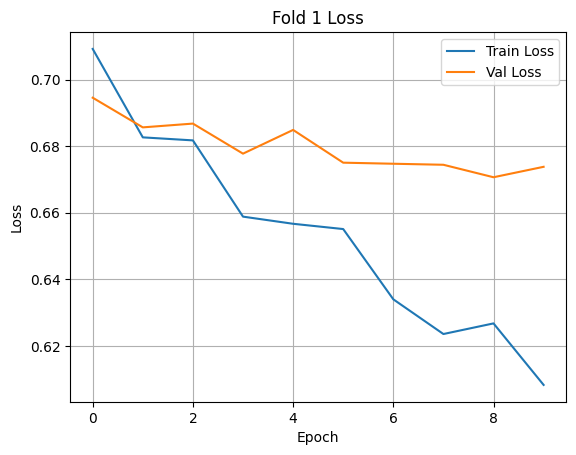

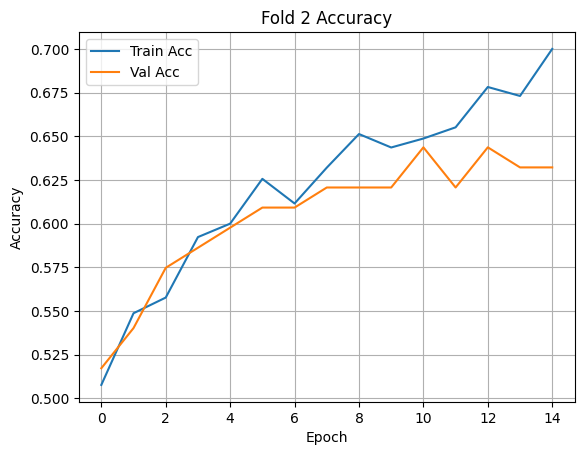

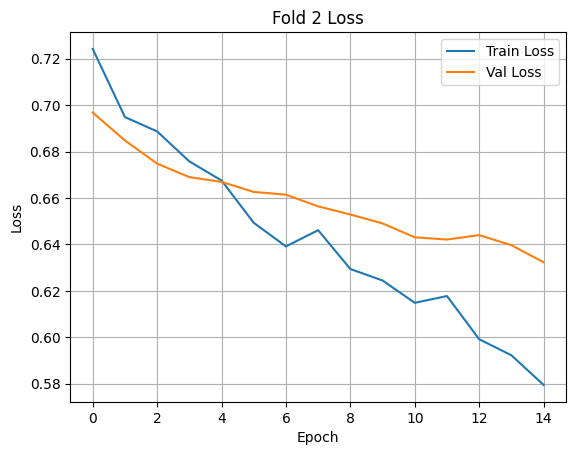

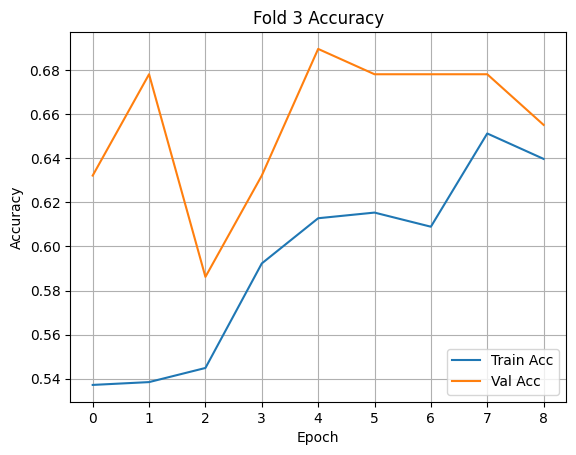

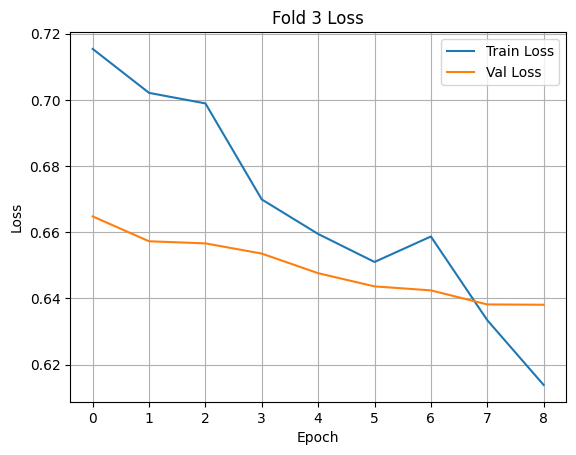

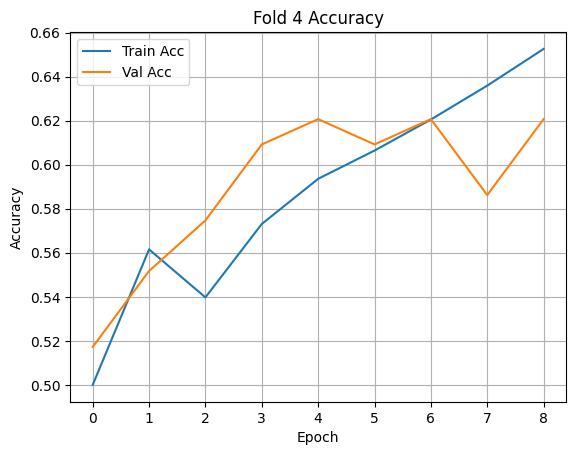

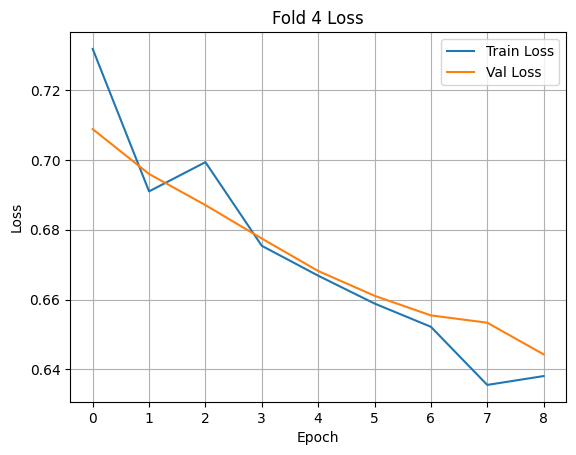

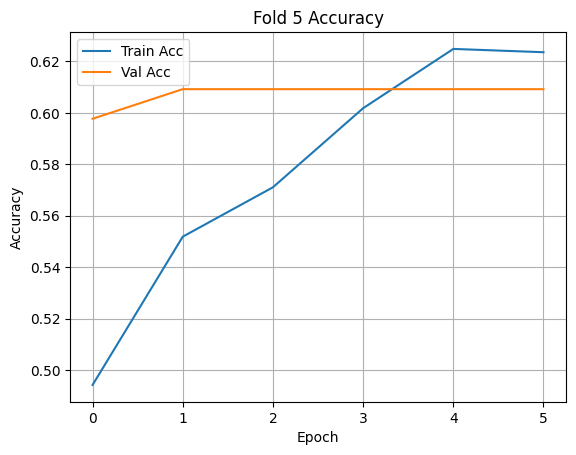

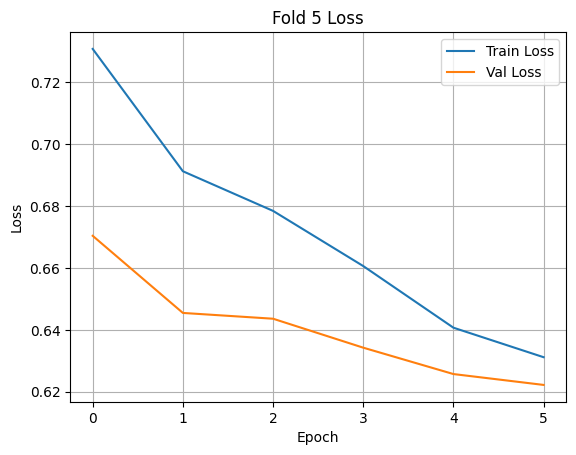

In [11]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_faceplus_final.h5")


/home/nhutai/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.745264
precision    0.760828
recall       0.737717
f1           0.747004
auc          0.684878
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.7453
📈 Range Accuracy: 0.3566
📉 Accuracy CV% (std/mean): 19.26%


,fold,accuracy,precision,recall,f1,auc
0,1,0.792627,0.853933,0.703704,0.771574,0.715936
1,2,0.718894,0.723810,0.703704,0.713615,0.698012
2,3,0.967742,1.000000,0.935780,0.966825,0.724601
3,4,0.635945,0.622951,0.697248,0.658009,0.638209
4,5,0.611111,0.603448,0.648148,0.625000,0.647634
